# day02 - И волки сыты

---

In [133]:
from random import randint, betavariate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta, date, time
import pylab
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
pylab.rcParams['figure.figsize'] = (15, 10)

---

## Моменты времени и протяженность во времени

Когда произошло событие? Сколько времени оно длилось? Эти два вопроса отличают моменты от продолжительности.  
Если уместно задать первый вопрос, или его аналог, то речь идет о моменте времени. Уместность второго вопроса свидетельствует о продолжительности. Данные по моментам и продолжительностям имеют разные сущности и требуют различные инструменты обработки при анализе. Рассмотрим на примере:

---

В файле *iCafe_train.xlsx* представлены данные одного дня интернет-кафе. Кафе принимает заказы на готовую еду и доставляет ее клиентам.  
Таблица содержит столбцы:
- Order_time - содержит информацию о времени размещения заказа на сайте, время представлено строкой вида 'h:mm:ss';
- Delivery_time - содержит информацию о времени, затраченном на доставку, время указано целым числом и характеризует количество минут, потребовавшихся на доставку от помещения кафе до клиента;
- Office - характеристика места доставки:
    - 1 - если доставка осуществлялась к месту работы клиента;
    - 0 - если доставка осуществлялась в жилой сектор. 

Нашей задачей будет определить, куда доставлялся заказ, на основании данных о времени его размещения и доставки.

Для начала импортируем данные из файла:

In [134]:
df = pd.read_excel('/Users/olgakalinina/Desktop/day02/datasets/iCafe_train.xlsx') # Создаем датафрейм df из файла
df                                                                                    # Смотрим, что в нем располагается

,Order_time,Delivery_time,Office
0,0:03:35,12,0
1,0:07:14,6,1
2,0:11:30,9,1
3,0:13:48,12,0
4,0:14:36,2,1
...,...,...,...
275,23:39:14,3,1
276,23:40:55,9,1
277,23:45:19,6,1
278,23:47:07,4,1


Строковые значение столбца Order_time не удобны с точки зрения математического анализа и визуализации, поэтому необходимо преобразовать данные к другому виду. Создадим столбец Order_time_sec, в котором будет представлена информация о времени размещения заказа в секундах. Для этого воспользуемся двумя функциями:
- ***to_timedelta*** модуля pandas, которая распарсит строку времени и определит отклонение результата от 0;
- ***timedelta64*** модуля numpy, которая позволит нам получить в знаменателе 1 секунду и, соответственно, весь результат в секундах. Изменение параметра 's' на 'm' или на 'h' позволит получать результат в минутах и часах соответственно.

In [135]:
df['Order_time_sec'] = pd.to_timedelta(df.Order_time) // np.timedelta64(1,'s') # Создаем столбец
df                                                                             # Смотрим результат

,Order_time,Delivery_time,Office,Order_time_sec
0,0:03:35,12,0,215
1,0:07:14,6,1,434
2,0:11:30,9,1,690
3,0:13:48,12,0,828
4,0:14:36,2,1,876
...,...,...,...,...
275,23:39:14,3,1,85154
276,23:40:55,9,1,85255
277,23:45:19,6,1,85519
278,23:47:07,4,1,85627


In [136]:
df.describe()

,Delivery_time,Office,Order_time_sec
count,280.000000,280.000000,280.000000
mean,7.675000,0.650000,50935.935714
std,3.303862,0.477824,18926.037837
min,2.000000,0.000000,215.000000
25%,5.000000,0.000000,41675.250000
50%,8.000000,1.000000,45775.000000
75%,9.000000,1.000000,68300.000000
max,18.000000,1.000000,86178.000000


Начинать анализ следует с того, чтобы понять что вообще происходит, какие наблюдаются правила, зависимости, попытаться понять процесс...

Для этого лучше всего визуализировать данные. Далее мы построим несколько графиков и попытаемся их интерпретировать.

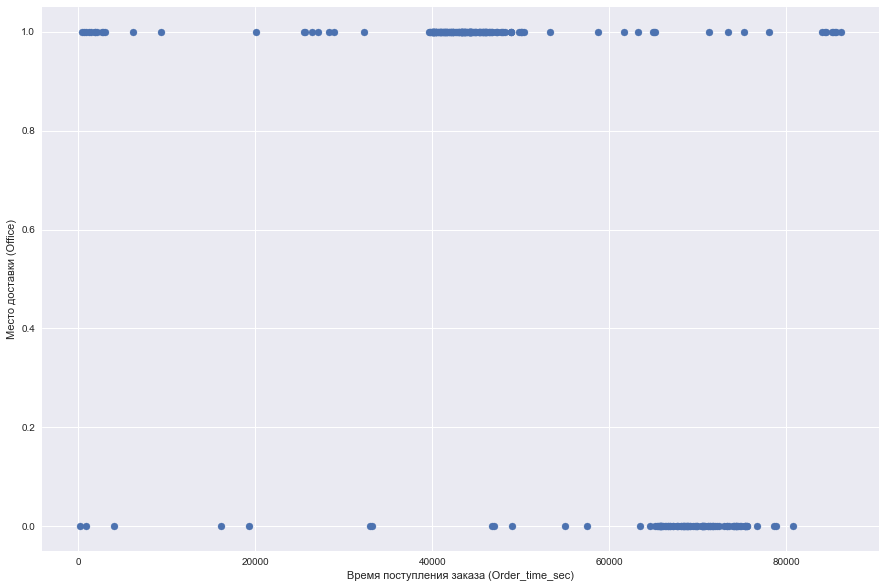

In [137]:
"""Строим график, где по оси абсцисс откладывается время поступления заказа, а по оси ординат место доставки"""

plt.scatter(df.Order_time_sec, df.Office)
plt.xlabel('Время поступления заказа (Order_time_sec)')
plt.ylabel('Место доставки (Office)')
plt.show()

Судя по графику, заказы в офис и не в офис по моменту поступления пересекаются, но кажется, что не очень сильно. Точнее мы сейчас определить не сможем.

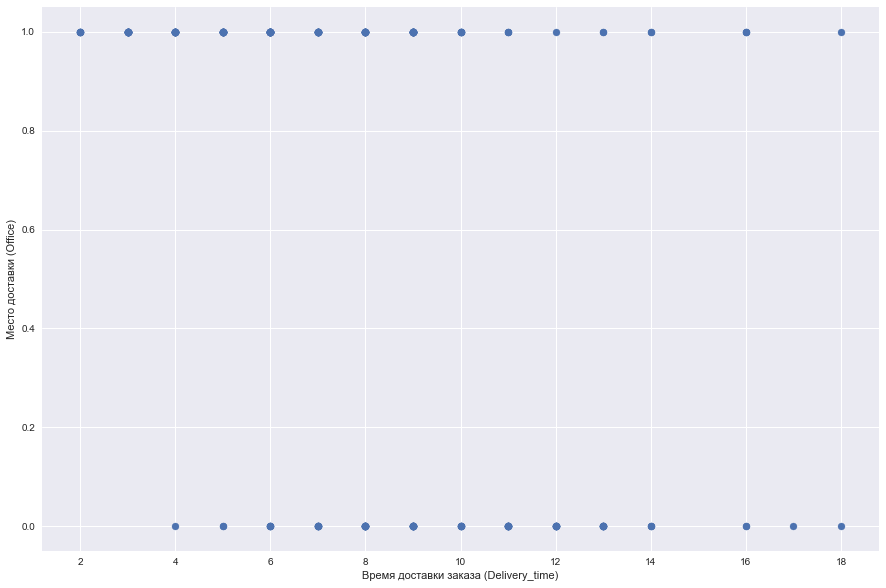

In [138]:
"""Строим график, где по оси абсцисс откладывается время доставки заказа, а по оси ординат место доставки"""

plt.scatter(df.Delivery_time, df.Office)
plt.xlabel('Время доставки заказа (Delivery_time)')
plt.ylabel('Место доставки (Office)')
plt.show()

Получили график, который не дает нам никакой информации. Это получилось в следствие того, что время доставки гораздо более дискретная величина, по сравнению с моментом размещения заказа, и у нас есть заказы из обоих классов почти для всех минут доставки. Построим другой график:

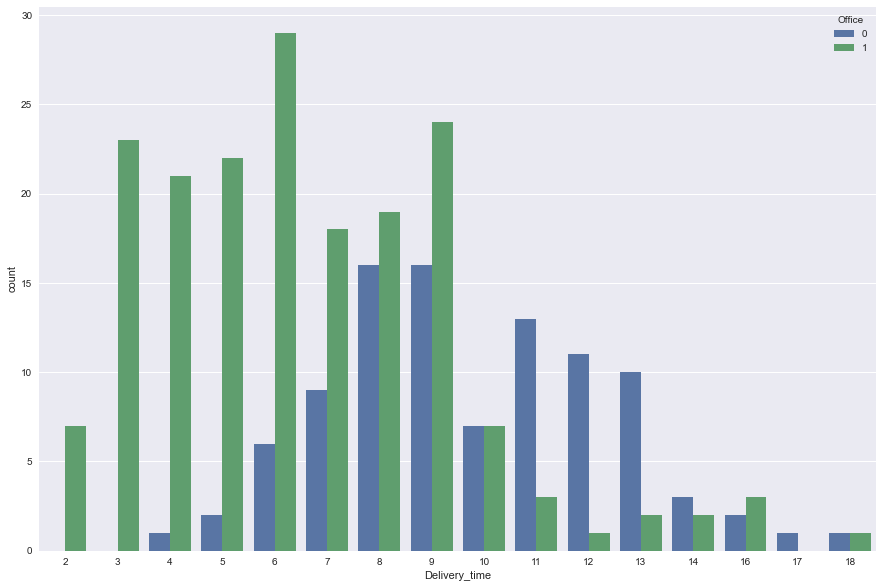

In [139]:
"""Строим диаграмму, где на каждое время доставки представлено количество доставок в офис и не в офис"""

sns.countplot(x = 'Delivery_time', hue = 'Office', data = df)
plt.show()

Из диаграммы мы видим, что в среднем в офис поставка осуществляется быстрее. Скорее всего помещение кафе располагается ближе к офисам, чем к жилым кварталам. Также мы видим, что чем дольше время доставки, тем меньше кафе получает заказов.

Попробуем построить подобный график для момента размещения заказа:

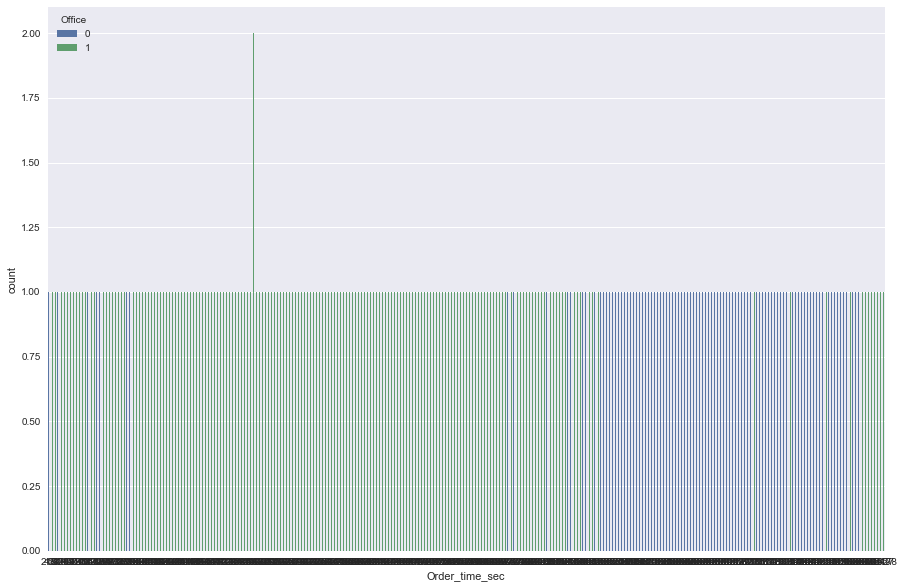

In [140]:
"""Строим диаграмму, где на каждое время размещения заказа представлено количество доставок в офис и не в офис"""

sns.countplot(x = 'Order_time_sec', hue = 'Office', data = df)
plt.show()

Опять получили лишенный смысла график. Здесь наблюдается обратная проблема. Заказы не поступают одноременно (за исключением одного случая, который следует рассматривать как случайное и крайне редкое событие). Для того, чтобы получить информативный график, нам необходимо собрать моменты поступления заказов во временные диапазоны, например, часовые. Создадим столбец Order_time_h, в который запишем час поступления заказа и построим диаграмму на полученных данных:

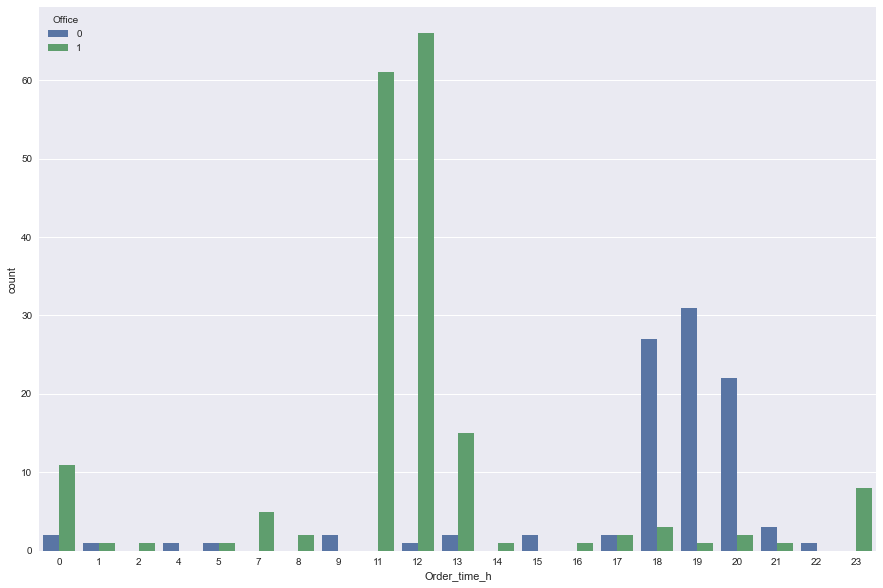

In [141]:
"""Строим диаграмму, где на каждый час времени размещения заказа представлено количество доставок 
   в офис и не в офис"""

df['Order_time_h'] = df.Order_time_sec//3600
sns.countplot(x = 'Order_time_h', hue = 'Office', data = df)
plt.show()

Вот теперь мы видим, что по моменту размещения заказа доля пересечения классов действительно не велика. Так же мы видим, что есть три больших всплеска заказов: 
- с 11 до 14 часов в офис - обеденный перерыв;
- с 18 до 22 часов на дом - для тех кто не хочет или не может готовить ужин;
- с 23 до 1 часа ночи в офис - дежурные на непрерывном производстве (например, тех. поддержка провайдеров)

Построим еще пару графиков, которые помогут нам позже построить классификатор

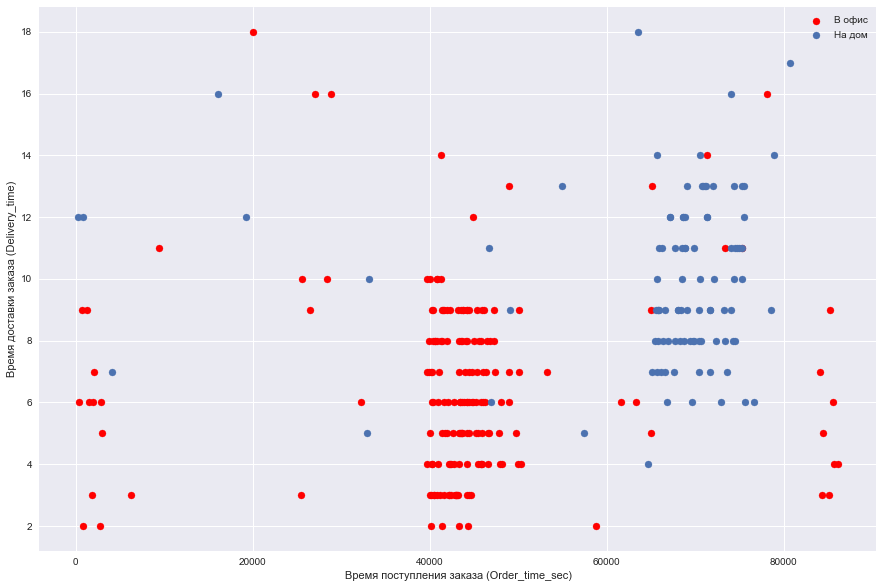

In [142]:
plt.scatter(df.Order_time_sec[df.Office == 1], df.Delivery_time[df.Office == 1], color = 'red')
plt.scatter(df.Order_time_sec[df.Office == 0], df.Delivery_time[df.Office == 0])
plt.legend(['В офис', 'На дом'])
plt.xlabel('Время поступления заказа (Order_time_sec)')
plt.ylabel('Время доставки заказа (Delivery_time)')
plt.show()

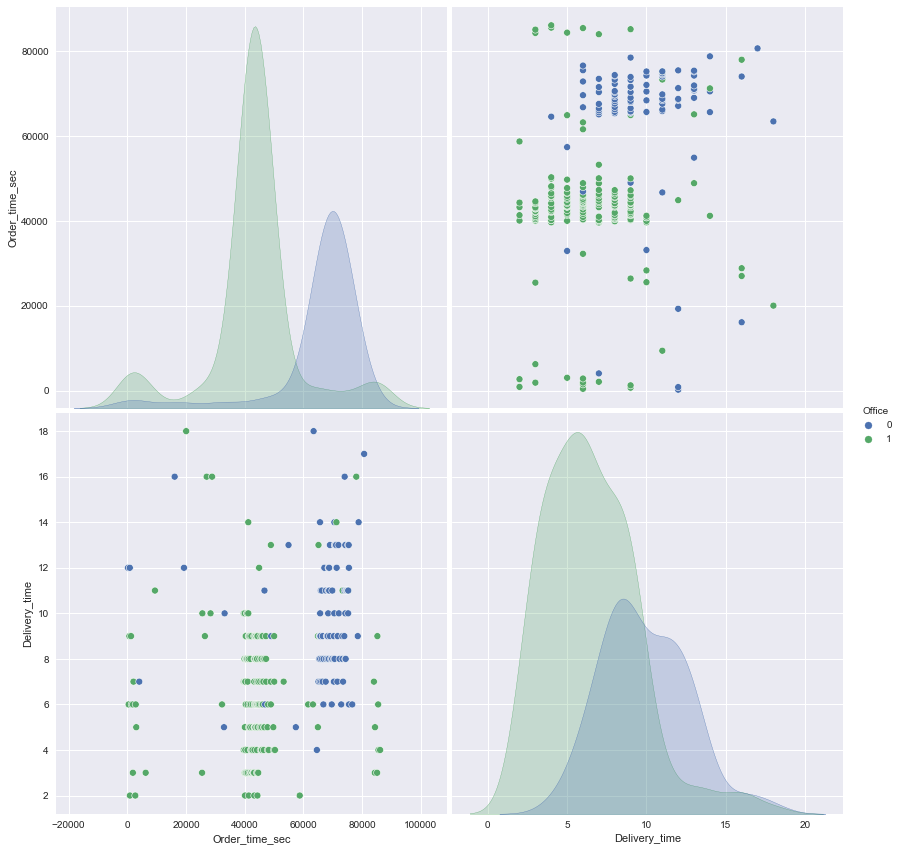

In [143]:
sns.pairplot(df[['Office', 'Order_time_sec', 'Delivery_time']], hue="Office", height=6)
plt.show()

In [144]:
"""Импортируем необходимые инструменты для построения классификатора"""

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [145]:
"""Разрабатываем классификатор"""

y = df.Office                                   # Определяем результирующий признак
X = df[['Order_time_sec', 'Delivery_time']]     # Определяем признаки

"""С помощью функции train_test_split разбиваем выборку на обучающую и тестовую. Параметр test_size указывает на 
   долю тестовой выборки. Если параметр random_state отличен от None, т.е. имеет конкретное значение, то 
   генерируемые псевдослучайные величины будут иметь одни и те же значения при каждом вызове, и мы будем каждый 
   раз получать одинаковое разбиение на обучающую и тестовую выборки. Условимся, что, если не указано другое, то
   по всему курсу обучения random_state=21"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

"""Функция StandardScaler приведет значения признаков к стандартному виду z = (x-u)/s, где u - среднее значение,
   а s - стандартное отклонение. Расчет среднего значения и стандартного отклонение осуществляется на выборке для 
   обучения, затем осуществляется преобразования данных для обучения и тестовых данных """
sc = StandardScaler()
sc.fit(X_train)                                  # Находим среднее и стандартное отклонение обучающей выборки
X_train_std = sc.transform(X_train)              # Преобразовываем обучающую выборку
X_test_std = sc.transform(X_test)                # Преобразовываем тестовую выборку

"""Формируем классификатор с помощью LogisticRegression. Коэффициенты уравнения логистической регрессии находятся
   на обучающей выборке, затем с помощью найденного уравнения предсказывается класс объекта на тестовой выборке"""
lr = LogisticRegression(random_state=21)
lr.fit(X_train_std, y_train)                     # Находим коэффициенты уравнения логистической регрессии
y_pred = lr.predict(X_test_std)                  # Определяем класс на значениях тестовых данных

print(classification_report(y_test, y_pred))     # Публикуем результаты качества модели на тестовой выборке

              precision    recall  f1-score   support

           0       0.76      0.88      0.81        25
           1       0.93      0.84      0.88        45

    accuracy                           0.86        70
   macro avg       0.84      0.86      0.85        70
weighted avg       0.87      0.86      0.86        70



---

Для анализа полученного результата напишем функцию *Processing_results()*, которой передаются значения:
- sc - действующий (полученный при разработке классификатора) метод стандартизации данных;
- lr - классификатор;
- df - датафрейм;
- target - название столбца целевого признака;
- attribute_name - список названий столбцов признаков;
- name - строка названия анализируемого результата;
- add_schedule - список списков признаков, для которых необходимо построить дополнительные графики (необязательный параметр)

In [146]:
def Processing_results(sc, lr, df, target, attribute_name, name, add_schedule = []):
    X_std = sc.transform(df[attribute_name])
    new_col_name = []
    for i, col_name in enumerate(attribute_name):
        s = col_name + '_std_' + name
        df[s] = X_std[:,i]
        new_col_name.append(s)
    y_pred = 'y_pred_' + name
    Correct = 'Correct_' + name
    df[y_pred] = lr.predict(X_std)
    df[Correct] = df.Office == df[y_pred]
    print(classification_report(df.Office, df[y_pred]))
    sns.pairplot(df[[Correct] + new_col_name], hue = Correct, height=round(12/len(new_col_name), 1))
    plt.show()
    for k in range(len(add_schedule)):
        i,j = add_schedule[k]
        i = i+'_std_'+name
        j = j+'_std_'+name
        plt.scatter(df[i][True ^ df[Correct]], df[j][True ^ df[Correct]], color = 'red')
        plt.scatter(df[i][df[Correct]], df[j][df[Correct]])
        plt.legend(['Определены не верно', 'Определены верно'])
        plt.xlabel(i)
        plt.ylabel(j)
        plt.show()
    return df

              precision    recall  f1-score   support

           0       0.81      0.84      0.82        98
           1       0.91      0.90      0.90       182

    accuracy                           0.88       280
   macro avg       0.86      0.87      0.86       280
weighted avg       0.88      0.88      0.88       280



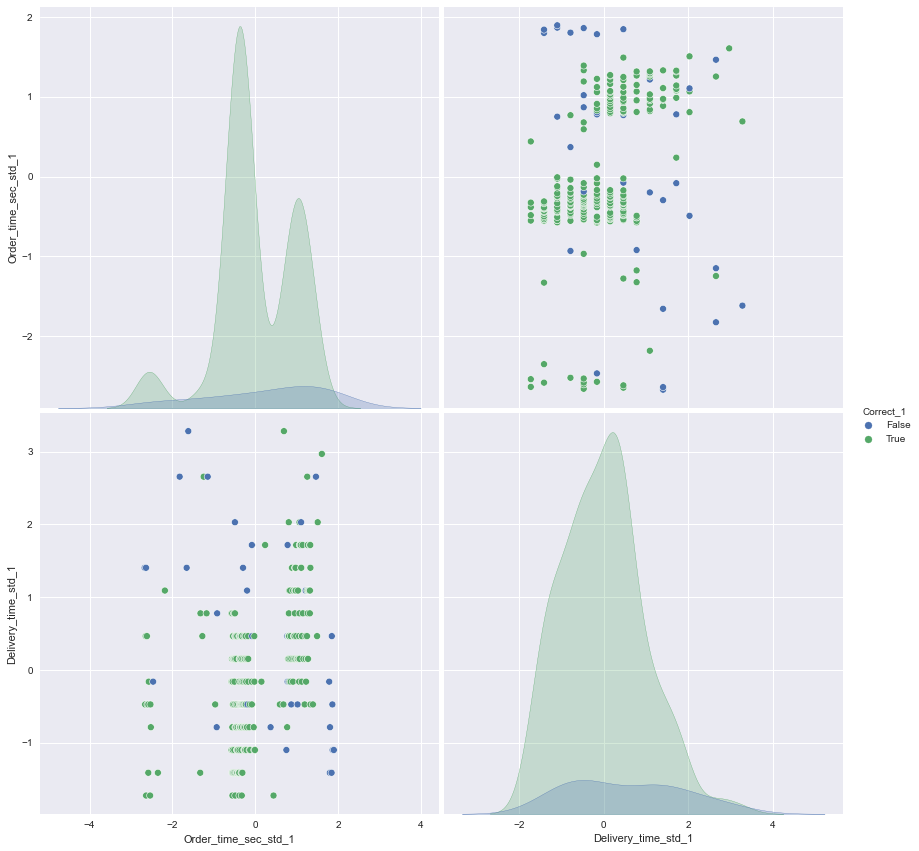

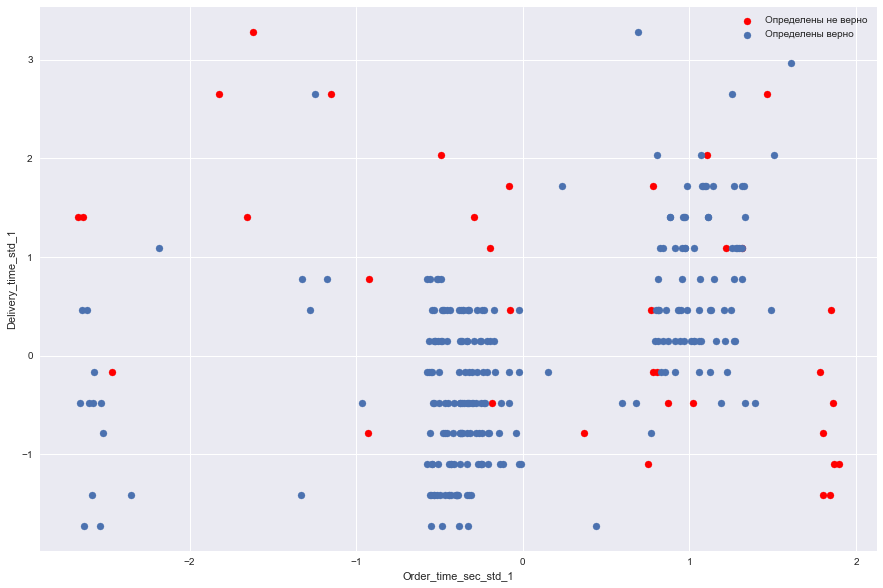

,Order_time,Delivery_time,Office,Order_time_sec,Order_time_h,Order_time_sec_std_1,Delivery_time_std_1,y_pred_1,Correct_1
0,0:03:35,12,0,215,0,-2.670995,1.403727,1,False
1,0:07:14,6,1,434,0,-2.659361,-0.473870,1,True
2,0:11:30,9,1,690,0,-2.645761,0.464929,1,True
3,0:13:48,12,0,828,0,-2.638430,1.403727,1,False
4,0:14:36,2,1,876,0,-2.635880,-1.725600,1,True
...,...,...,...,...,...,...,...,...,...
275,23:39:14,3,1,85154,23,1.841378,-1.412668,0,False
276,23:40:55,9,1,85255,23,1.846744,0.464929,0,False
277,23:45:19,6,1,85519,23,1.860769,-0.473870,0,False
278,23:47:07,4,1,85627,23,1.866506,-1.099735,0,False


In [147]:
y = 'Office'
x = ['Order_time_sec', 'Delivery_time']
df = Processing_results(sc, lr, df, y, x, '1', [x])
df

In [169]:
df_test = pd.read_excel('/Users/olgakalinina/Desktop/day02/datasets/iCafe_test.xlsx')
df_test['Order_time_sec'] = pd.to_timedelta(df_test.Order_time)//np.timedelta64(1,'s')
df_t1=df_test

y = 'Office'
x = ['Order_time_sec', 'Delivery_time']
df_test1 = Processing_results(sc, lr, df_t1, y1, x1, '1', [x])
df_test1

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        21
           1       0.94      0.94      0.94        47

    accuracy                           0.91        68
   macro avg       0.90      0.90      0.90        68
weighted avg       0.91      0.91      0.91        68



---

Путем двойного контроля мы убедились, что модель не переобучена и демонстрирует не плохое качество, все метрики на общей обучающей выборке 0.88, на тестовой выборке - 0.91. Можно ли улучшить полученное решение? Для ответа на этот вопрос в начале еще раз посмотрим на графики:

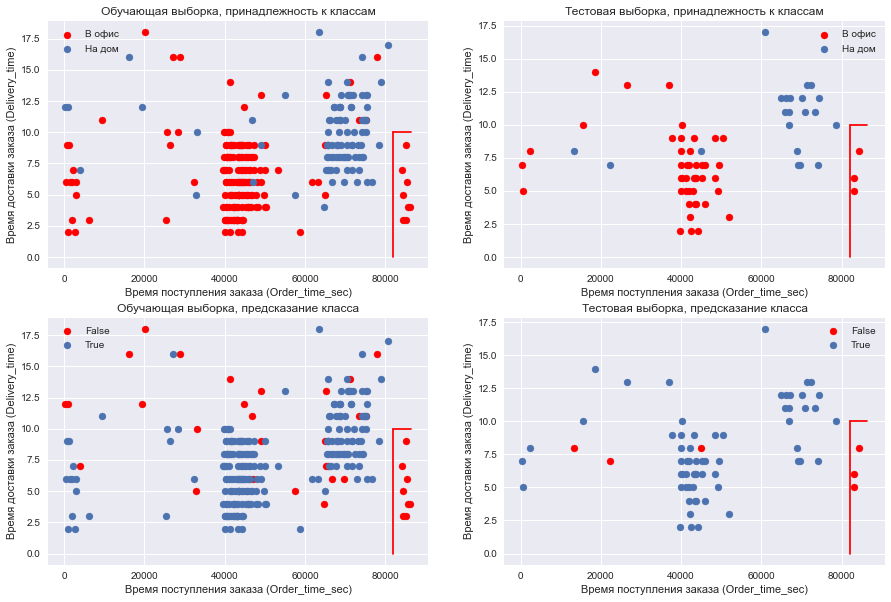

In [170]:
plt.subplot (2, 2, 1)
plt.scatter(df.Order_time_sec[df.Office == 1], df.Delivery_time[df.Office == 1], color = 'red')
plt.scatter(df.Order_time_sec[df.Office == 0], df.Delivery_time[df.Office == 0])
plt.legend(['В офис', 'На дом'])
plt.xlabel('Время поступления заказа (Order_time_sec)')
plt.ylabel('Время доставки заказа (Delivery_time)')
plt.plot([82000, 82000], [0,10], 'red')
plt.plot([82000, 86400], [10,10], 'red')
plt.title('Обучающая выборка, принадлежность к классам')

plt.subplot (2, 2, 2)
plt.scatter(df_test.Order_time_sec[df_test.Office == 1], df_test.Delivery_time[df_test.Office == 1], color = 'red')
plt.scatter(df_test.Order_time_sec[df_test.Office == 0], df_test.Delivery_time[df_test.Office == 0])
plt.legend(['В офис', 'На дом'])
plt.xlabel('Время поступления заказа (Order_time_sec)')
plt.ylabel('Время доставки заказа (Delivery_time)')
plt.plot([82000, 82000], [0,10], 'red')
plt.plot([82000, 86400], [10,10], 'red')
plt.title('Тестовая выборка, принадлежность к классам')

plt.subplot (2, 2, 3)
plt.scatter(df.Order_time_sec[True^df.Correct_1], df.Delivery_time[True^df.Correct_1], color = 'red')
plt.scatter(df.Order_time_sec[df.Correct_1], df.Delivery_time[df.Correct_1])
plt.legend(['False', 'True'])
plt.xlabel('Время поступления заказа (Order_time_sec)')
plt.ylabel('Время доставки заказа (Delivery_time)')
plt.plot([82000, 82000], [0,10], 'red')
plt.plot([82000, 86400], [10,10], 'red')
plt.title('Обучающая выборка, предсказание класса')

plt.subplot (2, 2, 4)
plt.scatter(df_test.Order_time_sec[True^df_test.Correct_1], df_test.Delivery_time[True^df_test.Correct_1], 
            color = 'red')
plt.scatter(df_test.Order_time_sec[df_test.Correct_1], df_test.Delivery_time[df_test.Correct_1])
plt.legend(['False', 'True'])
plt.xlabel('Время поступления заказа (Order_time_sec)')
plt.ylabel('Время доставки заказа (Delivery_time)')
plt.plot([82000, 82000], [0,10], 'red')
plt.plot([82000, 86400], [10,10], 'red')
plt.title('Тестовая выборка, предсказание класса')
plt.show()

На графиках мы видим одну и ту же область, где представители одного класса предсказываются неверно как на обучающей, так и на тестовой выборке. Попробуем исправить это!

1. Необходимо написать функцию time_change(df), которая записывает в датафрейм df столбец Order_time_sec_delta и возвращает полученный датафрейм. Столбец Order_time_sec_delta отличается от столбца Order_time_sec константой. В столбце Order_time_sec отметки времени расположены так, что последний заказ "на дом" (Office = 0) оказывается на отметке 86399 секунд от начала дня (т.е. ровно через сутки после начала). В этой функции нужно "сдвинуть" время всех заказов циклично влево, ближе к началу дня, на дельту, равную разнице \[24 часа - максимальное время заказа на дом во всем датафрейме].
2. Необходимо написать функцию log_reg(y, X), которая принимает на вход целевой признак y и столбцы датафрейма X, представляющие собой признаки. Функция возвращает обученные объекты sc и lr

In [171]:
def time_change(df):
    max_time_delivery=df.query("Office==0").Order_time_sec.max()
    delta = 24*60*60-max_time_delivery-1
    df['Order_time_sec_delta']=df['Order_time_sec']+delta
    df['Order_time_sec_delta']=df.Order_time_sec_delta.apply(lambda x: x - 86400 if x > 86400 else x)
    return(df)

def log_reg(y,X):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)
    
    sc = StandardScaler()
    sc=sc.fit(X_train) 
    
    X_train_std = sc.transform(X_train)              
    X_test_std = sc.transform(X_test) 
    
    lr = LogisticRegression(random_state=21)
    lr=lr.fit(X_train_std, y_train)
    
    return (sc, lr)

def Processing_results(sc, lr, df, target, attribute_name, name, add_schedule = []):
    X_std = sc.transform(df[attribute_name])
    new_col_name = []
    for i, col_name in enumerate(attribute_name):
        s = col_name + '_std_' + name
        df[s] = X_std[:,i]
        new_col_name.append(s)
    y_pred = 'y_pred_' + name
    Correct = 'Correct_' + name
    df[y_pred] = lr.predict(X_std)
    df[Correct] = df.Office == df[y_pred]
    print(classification_report(df.Office, df[y_pred]))

In [172]:
df2 = time_change(df)
y2 = 'Office'
x2 = ['Order_time_sec_delta', 'Delivery_time']
sc_delta, lr_delta = log_reg(df2[y], df2[x])
df_train2 = Processing_results(sc_delta, lr_delta, df2, y2, x2, 'delta', [x])
df_train2

              precision    recall  f1-score   support

           0       0.88      0.89      0.88        98
           1       0.94      0.93      0.94       182

    accuracy                           0.92       280
   macro avg       0.91      0.91      0.91       280
weighted avg       0.92      0.92      0.92       280



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Order_time_sec_delta
Feature names seen at fit time, yet now missing:
- Order_time_sec

  warnings.warn(message, FutureWarning)


In [173]:
df_t2 = time_change(df_test)
y2 = 'Office'
x2 = ['Order_time_sec_delta', 'Delivery_time']
df_test2 = Processing_results(sc_delta, lr_delta, df_t2, y2, x2, 'delta', [x])
df_test2

              precision    recall  f1-score   support

           0       0.90      0.86      0.88        21
           1       0.94      0.96      0.95        47

    accuracy                           0.93        68
   macro avg       0.92      0.91      0.91        68
weighted avg       0.93      0.93      0.93        68



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Order_time_sec_delta
Feature names seen at fit time, yet now missing:
- Order_time_sec

  warnings.warn(message, FutureWarning)


---

Мы улучшили качество классификатора за счет обеспечения монотонности целевой переменной от признаков, т.е. теперь выполняютя правила:
- чем больше момент времени поступления заказа, тем выше вероятность доставки на дом;
- чем выше время доставки, тем выше вероятность вероятность доставки на дом.

К сожалению, не всегда есть возможность обеспечить монотонность целевой переменной от признаков без применения каких-нибудь дополнительных инструментов.

Можно ли улучшить качество классификатора еще каким-нибудь способом? Это не только возможно, но и необходимо. 

Одним из способов улучшения классификатора является увеличение порядка пространства признаков, например, если на плоскости достаточно тяжело провести линию, разделяющую классы, то в трехмерном пространстве уже можно найти плоскость, которая сделает это лучше.

Все моменты времени необходимо преобразовывать через синус и косинус, формируя тем самым вместо одного два признака. Это становится тем более важным, если у нас вместо одного временного периода имеется несколько и существует возможность периодических колебаний.

Преобразования производятся по следующим формулам:
$$z_{sin} = sin\left(\frac{2\cdot\mathrm{\pi} \cdot \mathrm{x}}{ \mathrm{K} }\right)$$ 
$$z_{cos} = cos\left(\frac{2\cdot\mathrm{\pi} \cdot \mathrm{x}}{ \mathrm{K} }\right)$$ 

Здесь х - это значение момента времени, а К - значение временного периода в единицах измерения моментов времени.
Например: 
- если моменты времени измеряются в секундах, а временной период равен суткам, то К=86400;
- если моменты времени измеряются в днях, а временной период равен неделе, то К=7.

Проведем преобразование времени поступления заказа:

In [174]:
df['Order_sin'] = np.sin(df.Order_time_sec*math.pi/43200)
df['Order_cos'] = np.cos(df.Order_time_sec*math.pi/43200)
df

,Order_time,Delivery_time,Office,Order_time_sec,Order_time_h,Order_time_sec_std_1,Delivery_time_std_1,y_pred_1,Correct_1,Order_time_sec_delta,Order_time_sec_delta_std_delta,Delivery_time_std_delta,y_pred_delta,Correct_delta,Order_sin,Order_cos
0,0:03:35,12,0,215,0,-2.670995,1.403727,1,False,5877,-2.370202,1.403727,1,False,0.015635,0.999878
1,0:07:14,6,1,434,0,-2.659361,-0.473870,1,True,6096,-2.358568,-0.473870,1,True,0.031556,0.999502
2,0:11:30,9,1,690,0,-2.645761,0.464929,1,True,6352,-2.344968,0.464929,1,True,0.050157,0.998741
3,0:13:48,12,0,828,0,-2.638430,1.403727,1,False,6490,-2.337637,1.403727,1,False,0.060177,0.998188
4,0:14:36,2,1,876,0,-2.635880,-1.725600,1,True,6538,-2.335087,-1.725600,1,True,0.063661,0.997972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,23:39:14,3,1,85154,23,1.841378,-1.412668,0,False,4416,-2.447818,-1.412668,1,True,-0.090488,0.995898
276,23:40:55,9,1,85255,23,1.846744,0.464929,0,False,4517,-2.442452,0.464929,1,True,-0.083171,0.996535
277,23:45:19,6,1,85519,23,1.860769,-0.473870,0,False,4781,-2.428427,-0.473870,1,True,-0.064024,0.997948
278,23:47:07,4,1,85627,23,1.866506,-1.099735,0,False,4889,-2.422690,-1.099735,1,True,-0.056185,0.998420


Построим графики целевого показателя в пространстве полученных признаков:

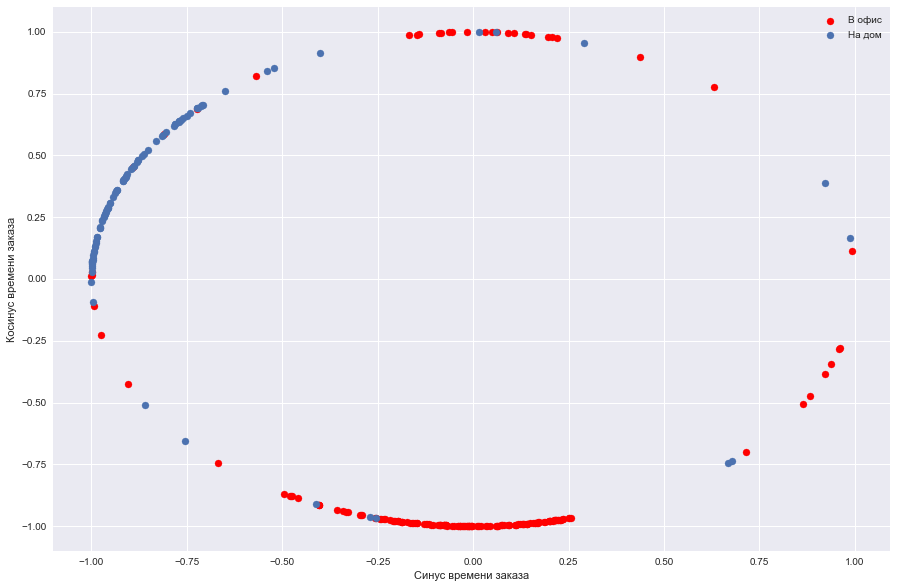

In [175]:
plt.scatter(df.Order_sin[df.Office == 1], df.Order_cos[df.Office == 1], color = 'red')
plt.scatter(df.Order_sin[df.Office == 0], df.Order_cos[df.Office == 0])
plt.legend(['В офис', 'На дом'])
plt.xlabel('Синус времени заказа')
plt.ylabel('Косинус времени заказа')
plt.show()

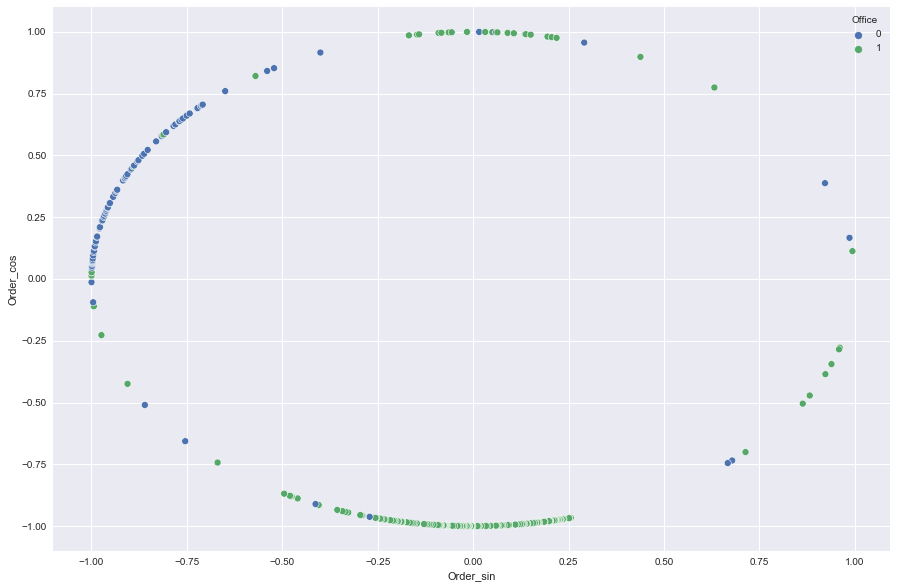

In [89]:
sns.scatterplot(x = 'Order_sin', y = 'Order_cos', data = df, hue = 'Office')
plt.show()

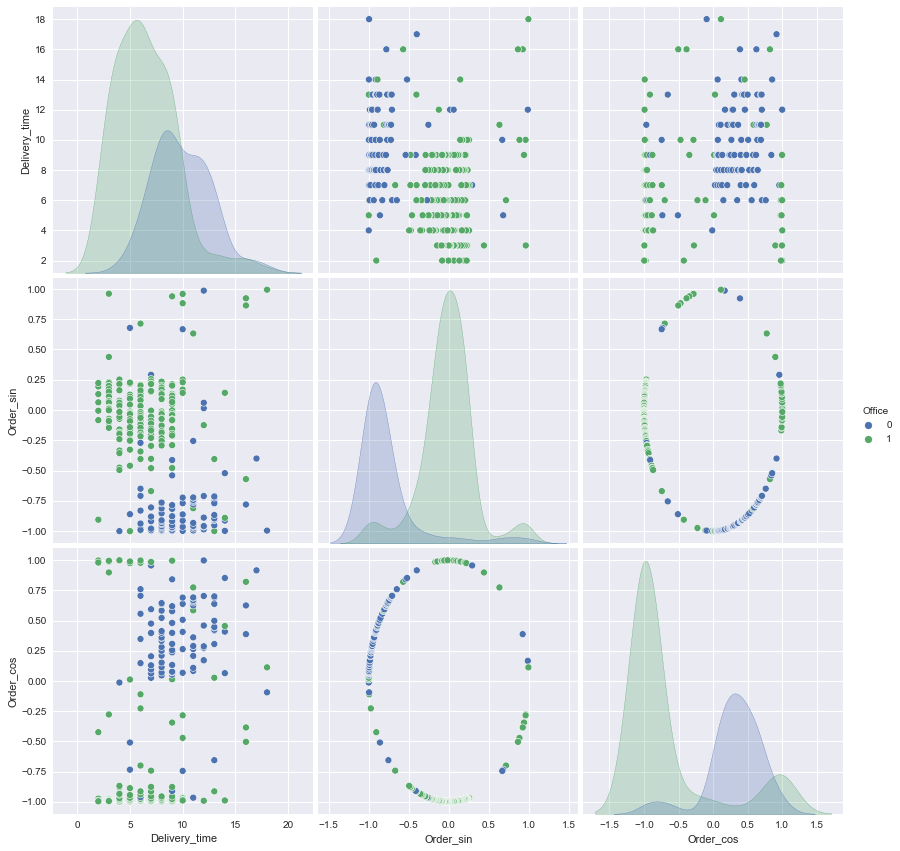

In [90]:
sns.pairplot(df[['Office', 'Delivery_time', 'Order_sin', 'Order_cos']], hue="Office", height=4)
plt.show()

Построим классификатор на преобразованых данных

In [176]:
y = df.Office
X = df[['Order_sin', 'Order_cos', 'Delivery_time']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

sc_2 = StandardScaler()
sc_2.fit(X_train)
X_train_std = sc_2.transform(X_train)
X_test_std = sc_2.transform(X_test)

lr_2 = LogisticRegression(random_state=21)
lr_2.fit(X_train_std, y_train)

y_pred_2 = lr_2.predict(X_test_std)

#print(classification_report(y_test, y_pred_2))

y = 'Office'
X = ['Order_sin', 'Order_cos', 'Delivery_time']
x = ['Order_sin', 'Order_cos']
df3 = Processing_results(sc_2, lr_2, df, y, X, '2', [x])
df3

              precision    recall  f1-score   support

           0       0.90      0.91      0.90        98
           1       0.95      0.95      0.95       182

    accuracy                           0.93       280
   macro avg       0.92      0.93      0.93       280
weighted avg       0.93      0.93      0.93       280



In [177]:
df_t3=df_test
df_t3['Order_sin'] = np.sin(df_t3.Order_time_sec*math.pi/43200)
df_t3['Order_cos'] = np.cos(df_t3.Order_time_sec*math.pi/43200)

y3 = 'Office'
X3 = ['Order_sin', 'Order_cos', 'Delivery_time']
x3 = ['Order_sin', 'Order_cos']
df_test3 = Processing_results(sc_2, lr_2, df_t3, y3, X3, '2', [x])
df_test3

              precision    recall  f1-score   support

           0       0.95      0.86      0.90        21
           1       0.94      0.98      0.96        47

    accuracy                           0.94        68
   macro avg       0.94      0.92      0.93        68
weighted avg       0.94      0.94      0.94        68



На общей выборке метрики показывают такой же результат, как и в задании 1, на тестовой выборе результат немного хуже.

---
Теперь возьмем данные со смещенным временем, произведем преобразование через синус и косинус, построим классификатор и сравним результаты.

In [178]:
df['Order_sin_new'] = np.sin(df.Order_time_sec_delta*math.pi/43200)
df['Order_cos_new'] = np.cos(df.Order_time_sec_delta*math.pi/43200)
df

,Order_time,Delivery_time,Office,Order_time_sec,Order_time_h,Order_time_sec_std_1,Delivery_time_std_1,y_pred_1,Correct_1,Order_time_sec_delta,...,Correct_delta,Order_sin,Order_cos,Order_sin_std_2,Order_cos_std_2,Delivery_time_std_2,y_pred_2,Correct_2,Order_sin_new,Order_cos_new
0,0:03:35,12,0,215,0,-2.670995,1.403727,1,False,5877,...,False,0.015635,0.999878,0.593465,1.799898,1.403727,0,True,0.414495,0.910052
1,0:07:14,6,1,434,0,-2.659361,-0.473870,1,True,6096,...,True,0.031556,0.999502,0.624683,1.799390,-0.473870,1,True,0.428935,0.903335
2,0:11:30,9,1,690,0,-2.645761,0.464929,1,True,6352,...,True,0.050157,0.998741,0.661154,1.798362,0.464929,1,True,0.445677,0.895194
3,0:13:48,12,0,828,0,-2.638430,1.403727,1,False,6490,...,False,0.060177,0.998188,0.680801,1.797614,1.403727,0,True,0.454638,0.890676
4,0:14:36,2,1,876,0,-2.635880,-1.725600,1,True,6538,...,True,0.063661,0.997972,0.687632,1.797322,-1.725600,1,True,0.457745,0.889084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,23:39:14,3,1,85154,23,1.841378,-1.412668,0,False,4416,...,True,-0.090488,0.995898,0.385390,1.794518,-1.412668,1,True,0.315649,0.948876
276,23:40:55,9,1,85255,23,1.846744,0.464929,0,False,4517,...,True,-0.083171,0.996535,0.399737,1.795380,0.464929,0,False,0.322610,0.946532
277,23:45:19,6,1,85519,23,1.860769,-0.473870,0,False,4781,...,True,-0.064024,0.997948,0.437277,1.797290,-0.473870,1,True,0.340721,0.940164
278,23:47:07,4,1,85627,23,1.866506,-1.099735,0,False,4889,...,True,-0.056185,0.998420,0.452649,1.797928,-1.099735,1,True,0.348095,0.937459


In [179]:
y = df.Office
X = df[['Order_sin_new', 'Order_cos_new', 'Delivery_time']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

sc_3 = StandardScaler()
sc_3.fit(X_train)
X_train_std = sc_3.transform(X_train)
X_test_std = sc_3.transform(X_test)

lr_3 = LogisticRegression(random_state=21)
lr_3.fit(X_train_std, y_train)

y_pred_3 = lr_3.predict(X_test_std)

y = 'Office'
X = ['Order_sin_new', 'Order_cos_new', 'Delivery_time']
x = ['Order_sin_new', 'Order_cos_new']
df4 = Processing_results(sc_3, lr_3, df, y, X, '3', [x])
df4

              precision    recall  f1-score   support

           0       0.90      0.91      0.90        98
           1       0.95      0.95      0.95       182

    accuracy                           0.93       280
   macro avg       0.92      0.93      0.93       280
weighted avg       0.93      0.93      0.93       280



In [180]:
df_t4=time_change(df_test)
df_t4['Order_sin_new'] = np.sin(df_test.Order_time_sec_delta*math.pi/43200)
df_t4['Order_cos_new'] = np.cos(df_test.Order_time_sec_delta*math.pi/43200)

y4 = 'Office'
X4 = ['Order_sin_new', 'Order_cos_new', 'Delivery_time']
x4 = ['Order_sin_new', 'Order_cos_new']
df_test4 = Processing_results(sc_3, lr_3, df_t4, y4, X4, '4', [x])

              precision    recall  f1-score   support

           0       1.00      0.86      0.92        21
           1       0.94      1.00      0.97        47

    accuracy                           0.96        68
   macro avg       0.97      0.93      0.95        68
weighted avg       0.96      0.96      0.95        68



In [181]:
Processing_results(sc, lr, df_t1, y1, x1, '1', [x])
Processing_results(sc_delta, lr_delta, df_t2, y2, x2, 'delta', [x])
Processing_results(sc_2, lr_2, df_t3, y3, X3, 'cos_sin', [x])
Processing_results(sc_3, lr_3, df_t3, y4, X4, 'cos_sin_delta', [x])

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        21
           1       0.94      0.94      0.94        47

    accuracy                           0.91        68
   macro avg       0.90      0.90      0.90        68
weighted avg       0.91      0.91      0.91        68

              precision    recall  f1-score   support

           0       0.90      0.86      0.88        21
           1       0.94      0.96      0.95        47

    accuracy                           0.93        68
   macro avg       0.92      0.91      0.91        68
weighted avg       0.93      0.93      0.93        68

              precision    recall  f1-score   support

           0       0.95      0.86      0.90        21
           1       0.94      0.98      0.96        47

    accuracy                           0.94        68
   macro avg       0.94      0.92      0.93        68
weighted avg       0.94      0.94      0.94        68

              preci

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Order_time_sec_delta
Feature names seen at fit time, yet now missing:
- Order_time_sec

  warnings.warn(message, FutureWarning)


---
Мы улучшили качество классификатора за счет обеспечения монотонности целевой переменной от признаков, а также за счет увеличения порядка пространства признаков.